In [1]:
import math
import torch
import gpytorch
import tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
myDim = 1000
train_x = 1/myDim*torch.randn((10000,myDim))

In [3]:
#train_x.sum(1)
train_x.size(0)

10000

In [4]:
#train_x = torch.linspace(0, 1, 10000)


train_y = torch.stack([
    torch.sin(train_x.sum(1) * (20 * math.pi)) + torch.randn(train_x.size(0)) * 0.2,
    torch.cos(train_x.sum(1) * (2 * math.pi)) + torch.randn(train_x.size(0)) * 0.2,
    torch.sin(train_x.sum(1) * (10 * math.pi)) + 2 * torch.cos(train_x.sum(1) * (2 * math.pi)) + torch.randn(train_x.size(0)) * 0.2,
    -torch.cos(train_x.sum(1) * (2 * math.pi)) + torch.randn(train_x.size(0)) * 0.2,
], -1)

print(train_x.shape, train_y.shape)

from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

#test_dataset = TensorDataset(test_x, test_y)
#test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)

torch.Size([10000, 1000]) torch.Size([10000, 4])


In [14]:
train_y.size()

10000

In [47]:
num_latents = 4
num_tasks = 4

class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.rand(num_latents, 1000, myDim)

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=4,
            num_latents=num_latents,
            latent_dim=-1
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])),
            batch_shape=torch.Size([num_latents])
        )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


model = MultitaskGPModel()
model.covar_module.base_kernel.lengthscale=torch.tensor([[[0.01]],[[0.1]],[[0.5]],[[1.0]]])
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)

In [48]:
likelihood(model(train_x)).rsample().shape

torch.Size([10000, 4])

In [49]:
output = model(train_x)
print(output.__class__.__name__, output.event_shape)

MultitaskMultivariateNormal torch.Size([10000, 4])


In [50]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_epochs = 1 if smoke_test else 1


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
# epochs_iter = tqdm.tqdm_notebook(range(num_epochs), desc="Epoch")
# for i in epochs_iter:
#     # Within each iteration, we will go over each minibatch of data
#     optimizer.zero_grad()
#     output = model(train_x)
#     loss = -mll(output, train_y)
#     epochs_iter.set_postfix(loss=loss.item())
#     loss.backward()
#     optimizer.step()

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    # Within each iteration, we will go over each minibatch of data
    minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
    for x_batch, y_batch in minibatch_iter:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        optimizer.step()


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/200 [00:00<?, ?it/s]

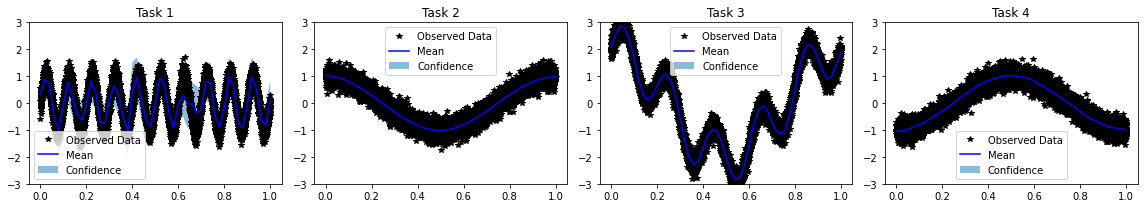

In [127]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

for task, ax in enumerate(axs):
    # Plot training data as black stars
    ax.plot(train_x.detach().numpy(), train_y[:, task].detach().numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.numpy(), mean[:, task].numpy(), 'b')
    # Shade in confidence
    ax.fill_between(test_x.numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Task {task + 1}')

fig.tight_layout()
None

In [34]:
model

MultitaskGPModel(
  (variational_strategy): LMCVariationalStrategy(
    (base_variational_strategy): VariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [ ]:
model.covar_module.base_kernel.lengthscale=0.1

In [67]:
model.covar_module.base_kernel.lengthscale=torch.tensor([[[0.1]],[[0.6]],[[0.2]],[[0.7]]])

In [94]:
model.covar_module.base_kernel.lengthscale

tensor([[[0.0387]],

        [[0.0382]],

        [[0.2475]],

        [[0.6152]]], grad_fn=<SoftplusBackward0>)